In [1]:
import os
import timeit
import numpy as np
import pandas as pd

import geopandas as gpd
import xarray as xr
import rioxarray
from geocube.api.core import make_geocube
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from utils import *


## Load in vector and raster data

In [2]:
data_path = "../../data/level_1_2_merged.gpkg"
world = gpd.read_file(data_path)
world.head()


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.1_1,Baharak,NA,NA,Wuleswali,District,NA,AF.BD.BA,None,None,None,None,None,None,"POLYGON ((71.41149 36.55717, 71.40954 36.55237..."
1,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.2_1,Darwaz,NA,NA,Wuleswali,District,NA,AF.BD.DA,None,None,None,None,None,None,"POLYGON ((71.27620 38.00465, 71.26561 38.00600..."
2,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.3_1,Fayzabad,NA,NA,Wuleswali,District,NA,AF.BD.FA,None,None,None,None,None,None,"POLYGON ((70.78272 37.27678, 70.78635 37.27388..."
3,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.4_1,Ishkashim,NA,NA,Wuleswali,District,NA,AF.BD.IK,None,None,None,None,None,None,"POLYGON ((71.42470 36.55388, 71.37926 36.56792..."
4,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.5_1,Jurm,NA,NA,Wuleswali,District,NA,AF.BD.JU,None,None,None,None,None,None,"POLYGON ((70.71236 37.07621, 70.73582 37.06548..."


In [3]:
world["polygon_id"] = world.index.values
world.head()


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,CC_2,HASC_2,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry,polygon_id
0,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.1_1,Baharak,NA,NA,Wuleswali,...,NA,AF.BD.BA,None,None,None,None,None,None,"POLYGON ((71.41149 36.55717, 71.40954 36.55237...",0
1,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.2_1,Darwaz,NA,NA,Wuleswali,...,NA,AF.BD.DA,None,None,None,None,None,None,"POLYGON ((71.27620 38.00465, 71.26561 38.00600...",1
2,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.3_1,Fayzabad,NA,NA,Wuleswali,...,NA,AF.BD.FA,None,None,None,None,None,None,"POLYGON ((70.78272 37.27678, 70.78635 37.27388...",2
3,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.4_1,Ishkashim,NA,NA,Wuleswali,...,NA,AF.BD.IK,None,None,None,None,None,None,"POLYGON ((71.42470 36.55388, 71.37926 36.56792...",3
4,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.5_1,Jurm,NA,NA,Wuleswali,...,NA,AF.BD.JU,None,None,None,None,None,None,"POLYGON ((70.71236 37.07621, 70.73582 37.06548...",4


In [4]:
world.tail()


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,CC_2,HASC_2,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry,polygon_id
47852,ZNC,Northern Cyprus,ZNC.1_1,Gazimağusa,Αμμόχωστος,ZNC.1_1,None,None,None,None,...,None,None,Famagusta|Gazimagusa,Kaza,District,NA,NA,NA,"POLYGON ((33.90652 35.06912, 33.91445 35.07306...",47852
47853,ZNC,Northern Cyprus,ZNC.2_1,Girne,Κερύvεια,ZNC.2_1,None,None,None,None,...,None,None,Kyrenia,Kaza,District,NA,NA,NA,"MULTIPOLYGON (((33.66407 35.36236, 33.65671 35...",47853
47854,ZNC,Northern Cyprus,ZNC.3_1,Güzelyurt,NA,ZNC.3_1,None,None,None,None,...,None,None,Morphou,Kaza,District,NA,NA,NA,"MULTIPOLYGON (((33.12013 35.16034, 33.10912 35...",47854
47855,ZNC,Northern Cyprus,ZNC.4_1,Iskele,NA,ZNC.4_1,None,None,None,None,...,None,None,Trikomo,Kaza,District,NA,NA,NA,"MULTIPOLYGON (((34.60764 35.71181, 34.60375 35...",47855
47856,ZNC,Northern Cyprus,ZNC.5_1,Nicosia,Λευκωσία,ZNC.5_1,None,None,None,None,...,None,None,Lefkosa,Kaza,District,NA,NA,NA,"POLYGON ((33.66292 35.03827, 33.65252 35.03431...",47856


In [5]:
world.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

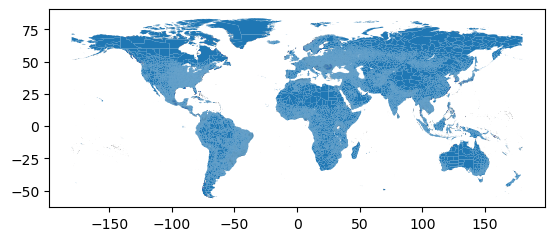

In [6]:
world.plot()
plt.show()


In [7]:
name = 'tavg'
# name = 'precip'

if name == 'tavg':
    cmap = "RdBu_r"
    colormap = cm.RdBu_r
    raster = load_tavg_data()
    
elif name == 'precip':
    cmap = 'Blues'
    colormap = cm.Blues
    raster = load_precip_data()

else:
    print('Dataset not yet supported')


In [8]:
raster


<xarray.DataArray 'tavg' (band: 1, y: 1080, x: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * x            (x) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
  * y            (y) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
    spatial_ref  int64 ...
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  34.009499740601
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -45.884000024796
    STATISTICS_STDDEV:   nan

In [9]:
min_value = raster.min(skipna=True).data
max_value = raster.max(skipna=True).data
print(min_value, max_value)


-45.884 34.0095


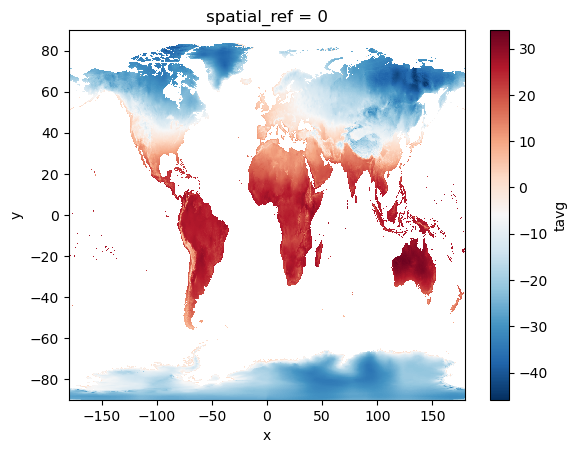

In [10]:
raster.plot(cmap=cmap, vmin=min_value, vmax=max_value)
plt.show()


## Creating the burned raster

The code below is the same code found in `utils.py` in this directory, but is broken down into smaller chunks so that we can view the output at each step.

In [11]:
raster


<xarray.DataArray 'tavg' (band: 1, y: 1080, x: 2160)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-16.99   , -17.92   , ..., -19.73275, -18.20025],
        [-17.2735 , -17.8625 , ..., -19.67225, -18.494  ]]], dtype=float32)
Coordinates:
  * x            (x) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
  * y            (y) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
    spatial_ref  int64 ...
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  34.009499740601
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -45.884000024796
    STATISTICS_STDDEV:   nan

In [12]:
gdf = world
data = raster
load_data = True
interp = None
clip = False

start = timeit.default_timer()
#---------------------------------------------------------------------------

if clip:
    # Clip to the external bounds of the input geometry
    # minx, miny, maxx, maxy = vector_grid.total_bounds
    # data = data.sel(x=slice(minx, maxx), y=slice(miny, maxy))

    # in our case, the geometry is the whole world, either land or ocean grid
    min_x, max_x = data.x.min().values, data.x.max().values
    min_y, max_y = data.y.min().values, data.y.max().values

# interpolate to a finer grid first
if interp is not None and interp > 1:
    new_x  = np.linspace( data.x[0], data.x[-1], int(len(data.x) * interp) )
    new_y  = np.linspace( data.y[0], data.y[-1], int(len(data.y) * interp) )
    data = data.interp( x = new_x, y = new_y, method='nearest' )

# load data to disk before analysis (much quicker).
if load_data:
    data = data.load()

# burn polygon indices ('index' in dataframe ) onto same raster as data
burned = make_geocube( vector_data = gdf,
                       measurements = ["polygon_id"],
                       like = data )

# get indices of rasters that successfully burned (some will have been too small)
#success_idx = np.unique( burned.polygon_id ).astype(int) # this line will convert float nan to 0, which seems like a bug
success_idx = np.array([int(success) for success in np.unique( burned.polygon_id ).tolist() if np.isnan(success) == False])
success_idx = success_idx[ success_idx >=0 ]

#---------------------------------------------------------------------------
end = timeit.default_timer()
print(f"Time to complete: {(end - start):.5f}s")


Time to complete: 7.60017s


In [13]:
print(len(success_idx))
print(len(gdf))


34397
47857


So about 13k polygons are too small.

In [14]:
burned


<xarray.Dataset>
Dimensions:      (y: 1080, x: 2160)
Coordinates:
  * y            (y) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
  * x            (x) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
    spatial_ref  int64 0
Data variables:
    polygon_id   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

## Zonal stats

In [15]:
skipna = True

# Group together the raster data by polygon index
data['polygon_id'] = (['y','x'], burned.polygon_id.values )
polygon_groups = data.groupby('polygon_id')
print(polygon_groups)


DataArrayGroupBy, grouped over 'polygon_id'
34397 groups with labels 0.0, 1.0, ..., 4.786e+04.


In [16]:
burned.polygon_id.values


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [17]:
# Get statistics for burned raster analysis
gdf_stats = gdf[['geometry']]
gdf_stats[data.name + "_value"] = np.zeros( len(gdf) ) 
gdf_stats[data.name + "_count"] = np.zeros( len(gdf) ) 
gdf_stats[data.name + "_std"] = np.zeros( len(gdf) ) 

gdf_stats.head()


,geometry,tavg_value,tavg_count,tavg_std
0,"POLYGON ((71.41149 36.55717, 71.40954 36.55237...",0.0,0.0,0.0
1,"POLYGON ((71.27620 38.00465, 71.26561 38.00600...",0.0,0.0,0.0
2,"POLYGON ((70.78272 37.27678, 70.78635 37.27388...",0.0,0.0,0.0
3,"POLYGON ((71.42470 36.55388, 71.37926 36.56792...",0.0,0.0,0.0
4,"POLYGON ((70.71236 37.07621, 70.73582 37.06548...",0.0,0.0,0.0


In [18]:
gdf_stats.tail()


,geometry,tavg_value,tavg_count,tavg_std
47852,"POLYGON ((33.90652 35.06912, 33.91445 35.07306...",0.0,0.0,0.0
47853,"MULTIPOLYGON (((33.66407 35.36236, 33.65671 35...",0.0,0.0,0.0
47854,"MULTIPOLYGON (((33.12013 35.16034, 33.10912 35...",0.0,0.0,0.0
47855,"MULTIPOLYGON (((34.60764 35.71181, 34.60375 35...",0.0,0.0,0.0
47856,"POLYGON ((33.66292 35.03827, 33.65252 35.03431...",0.0,0.0,0.0


In [19]:
start = timeit.default_timer()
#---------------------------------------------------------------------------

gdf_stats[data.name + "_value"].loc[success_idx] = polygon_groups.mean( skipna = skipna ).values.squeeze()
gdf_stats[data.name + "_count"].loc[success_idx] = polygon_groups.count( ).values.squeeze()
gdf_stats[data.name + "_std"].loc[success_idx] = polygon_groups.std( skipna = skipna ).values.squeeze()

# For missing rows (polygon too small) interpolate to centroids
missing_idx = np.array( [ ii for ii in gdf.polygon_id.values if ii not in success_idx ] )

cent = gdf.loc[missing_idx].geometry.centroid
cent_x = [cc.x for cc in cent]
cent_y = [cc.y for cc in cent]
data_cent = data.interp( 
    x = xr.DataArray( cent_x ), 
    y = xr.DataArray( cent_y ),
    method="nearest"
)

gdf_stats[data.name + "_value"][missing_idx] = data_cent.values.squeeze()

#---------------------------------------------------------------------------
end = timeit.default_timer()
print(f"Time to complete: {(end - start):.5f}s")


Time to complete: 12.04287s


In [20]:
gdf_stats[data.name + "_value"] = np.round(gdf_stats[data.name + "_value"], 3)
gdf_stats


,geometry,tavg_value,tavg_count,tavg_std
0,"POLYGON ((71.41149 36.55717, 71.40954 36.55237...",-8.784,12.0,3.285399
1,"POLYGON ((71.27620 38.00465, 71.26561 38.00600...",-9.694,13.0,2.755260
2,"POLYGON ((70.78272 37.27678, 70.78635 37.27388...",-3.674,10.0,2.547918
3,"POLYGON ((71.42470 36.55388, 71.37926 36.56792...",-11.043,6.0,1.671929
4,"POLYGON ((70.71236 37.07621, 70.73582 37.06548...",-6.905,10.0,3.022684
...,...,...,...,...
47852,"POLYGON ((33.90652 35.06912, 33.91445 35.07306...",10.564,3.0,0.217880
47853,"MULTIPOLYGON (((33.66407 35.36236, 33.65671 35...",10.253,2.0,0.079000
47854,"MULTIPOLYGON (((33.12013 35.16034, 33.10912 35...",10.710,1.0,0.000000
47855,"MULTIPOLYGON (((34.60764 35.71181, 34.60375 35...",10.745,3.0,0.397535


In [21]:
min_mean, max_mean = gdf_stats[data.name + "_value"].min(), gdf_stats[data.name + "_value"].max()
print(min_mean, max_mean)


-42.59 32.605


Now let's see how the original raster data compares with our new vector dataset.

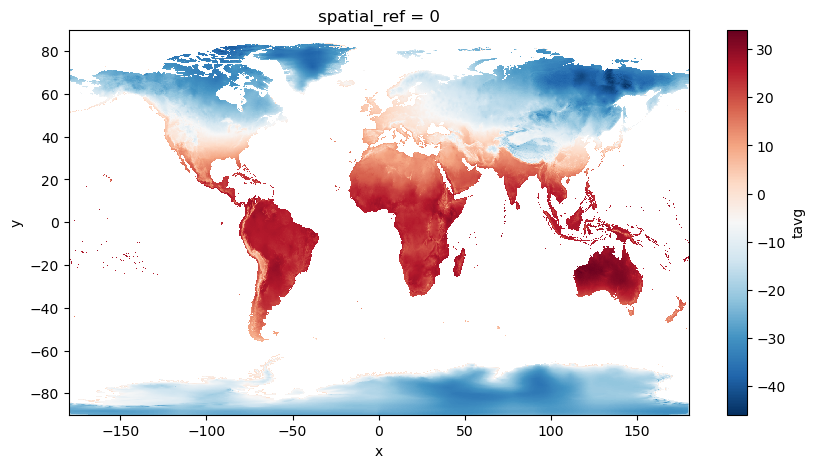

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
raster.plot(cmap=cmap, vmin=min_value, vmax=max_value, ax=ax)
plt.show()


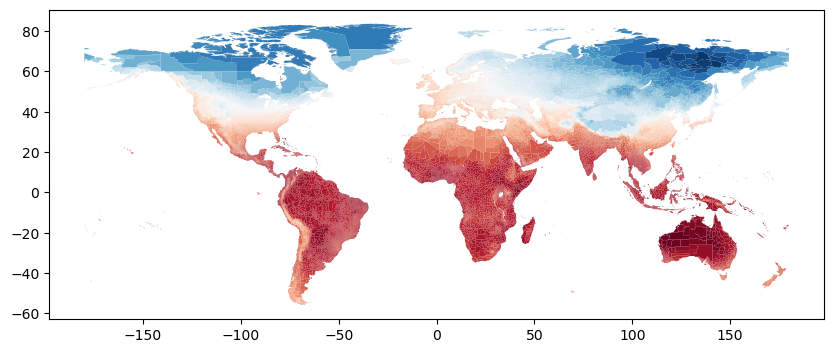

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
gdf_stats.plot(column=data.name + "_value", cmap=cmap, vmin=min_mean, vmax=max_mean, ax=ax)
plt.show()


In [24]:
gdf_stats = gdf_stats.join(world.GID_2)
gdf_stats


,geometry,tavg_value,tavg_count,tavg_std,GID_2
0,"POLYGON ((71.41149 36.55717, 71.40954 36.55237...",-8.784,12.0,3.285399,AFG.1.1_1
1,"POLYGON ((71.27620 38.00465, 71.26561 38.00600...",-9.694,13.0,2.755260,AFG.1.2_1
2,"POLYGON ((70.78272 37.27678, 70.78635 37.27388...",-3.674,10.0,2.547918,AFG.1.3_1
3,"POLYGON ((71.42470 36.55388, 71.37926 36.56792...",-11.043,6.0,1.671929,AFG.1.4_1
4,"POLYGON ((70.71236 37.07621, 70.73582 37.06548...",-6.905,10.0,3.022684,AFG.1.5_1
...,...,...,...,...,...
47852,"POLYGON ((33.90652 35.06912, 33.91445 35.07306...",10.564,3.0,0.217880,ZNC.1_1
47853,"MULTIPOLYGON (((33.66407 35.36236, 33.65671 35...",10.253,2.0,0.079000,ZNC.2_1
47854,"MULTIPOLYGON (((33.12013 35.16034, 33.10912 35...",10.710,1.0,0.000000,ZNC.3_1
47855,"MULTIPOLYGON (((34.60764 35.71181, 34.60375 35...",10.745,3.0,0.397535,ZNC.4_1


## Creating a colormap for future use
We are going to create a custom colormap and then map those colors to each value in our `gdf_stats` dataframe. This makes it easy to read in colors for each geometry in Mapbox. But first, to save space, we are going to drop the `count` and `std` columns.

In [25]:
gdf_stats.drop(data.name + "_count", axis=1, inplace=True)
gdf_stats.drop(data.name + "_std", axis=1, inplace=True)
gdf_stats.head()


,geometry,tavg_value,GID_2
0,"POLYGON ((71.41149 36.55717, 71.40954 36.55237...",-8.784,AFG.1.1_1
1,"POLYGON ((71.27620 38.00465, 71.26561 38.00600...",-9.694,AFG.1.2_1
2,"POLYGON ((70.78272 37.27678, 70.78635 37.27388...",-3.674,AFG.1.3_1
3,"POLYGON ((71.42470 36.55388, 71.37926 36.56792...",-11.043,AFG.1.4_1
4,"POLYGON ((70.71236 37.07621, 70.73582 37.06548...",-6.905,AFG.1.5_1


In [26]:
norm = cm.colors.Normalize(vmin=min_value, vmax=max_value)
cmap = colormap

def rgba2hex(value, normalizer, colormap):
    rgba = np.array(colormap(normalizer(value), bytes=True))
    hex = cm.colors.to_hex(rgba / 255.)
    return hex

gdf_stats[data.name + "_color"] = gdf_stats.apply(lambda row: rgba2hex(row[data.name + "_value"], norm, cmap), axis = 1)
gdf_stats.head()


,geometry,tavg_value,GID_2,tavg_color
0,"POLYGON ((71.41149 36.55717, 71.40954 36.55237...",-8.784,AFG.1.1_1,#e8f0f4
1,"POLYGON ((71.27620 38.00465, 71.26561 38.00600...",-9.694,AFG.1.2_1,#e4eef3
2,"POLYGON ((70.78272 37.27678, 70.78635 37.27388...",-3.674,AFG.1.3_1,#f8eee8
3,"POLYGON ((71.42470 36.55388, 71.37926 36.56792...",-11.043,AFG.1.4_1,#deebf2
4,"POLYGON ((70.71236 37.07621, 70.73582 37.06548...",-6.905,AFG.1.5_1,#f1f4f6


In [27]:
# gdf_stats.to_file(f'../../data/{name}_vec2raster_gadm.gpkg', driver='GPKG', layer=f'{name}_vec2raster_gadm') 
# with open(f"../../data/{name}_vec2raster_gadm.json", "w") as file:
#   file.write(gdf_stats.to_json())


In [28]:
# highest resolution: 3.599 GB when saving floats to 3 decimals, 3.6 GB without rounding
# high resolution: 389 MB when saving floats to 3 decimals, 390 MB without rounding
filesize = np.round(os.path.getsize(f"../../data/{name}_vec2raster_gadm.json") / 1e6, 3)
print(f"The file is {filesize} MB")


The file is 389.156 MB


## Investigating missing data

For many very small polygons (almost, but not all, islands), this method does not work well. This is a function of a given polygons centroid lying outside of small, sometimes separated geometries (which is why the method doesn't work well for some island nations). If you zoom in, you can see that these small polygons are colored in blue. The following printouts show which countries these polygons are apart of (according to GADM).

In [29]:
np.sum(np.isnan(gdf_stats[data.name + "_value"]))


56

In [30]:
world[np.isnan(gdf_stats[data.name + "_value"])]


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,CC_2,HASC_2,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry,polygon_id
1256,AUS,Australia,AUS.3_1,Coral Sea Islands Territory,NA,AUS.3.1_1,Coral Sea Islands,NA,NA,Territory,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((155.53674 -23.25240, 155.53841...",1256
1791,AUS,Australia,AUS.11_1,Western Australia,NA,AUS.11.110_1,Scott and Seringapatam Reefs,NA,NA,Islands,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((122.01866 -13.64137, 122.00918...",1791
10935,COL,Colombia,COL.27_1,San Andrés y Providencia,NA,COL.27.1_2,Islas Serranilla,Serranilla Bank,NA,Islas,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((-78.55121 15.90912, -78.55310 ...",10935
14812,FSM,Micronesia,FSM.1_1,Chuuk,NA,FSM.1.4_1,Fayo,NA,NA,Municipality,...,NA,NA,None,None,None,None,None,None,"POLYGON ((151.34134 8.54382, 151.33917 8.54942...",14812
14817,FSM,Micronesia,FSM.1_1,Chuuk,NA,FSM.1.9_1,Makur,NA,NA,Municipality,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((150.42383 8.56696, 150.42021 8...",14817
14818,FSM,Micronesia,FSM.1_1,Chuuk,NA,FSM.1.10_1,Murilo,NA,NA,Municipality,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((152.33888 8.69889, 152.34334 8...",14818
14822,FSM,Micronesia,FSM.1_1,Chuuk,NA,FSM.1.14_1,Nomwin,NA,NA,Municipality,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((151.91325 8.56037, 151.91447 8...",14822
14827,FSM,Micronesia,FSM.1_1,Chuuk,NA,FSM.1.19_1,Piis-Penau,NA,NA,Municipality,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((151.99834 7.42528, 151.99861 7...",14827
14856,FSM,Micronesia,FSM.3_1,Pohnpei,NA,FSM.3.12_1,Sapwuahfik,Ngatik,NA,Municipality,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((157.33722 5.78528, 157.34056 5...",14856
14860,FSM,Micronesia,FSM.4_1,Yap,NA,FSM.4.2_1,Eauripik,NA,NA,Municipality,...,NA,NA,None,None,None,None,None,None,"MULTIPOLYGON (((143.07388 6.68333, 143.08055 6...",14860


In [31]:
np.unique(world[np.isnan(gdf_stats[data.name + "_value"])].COUNTRY)


array(['Anguilla', 'Australia', 'Colombia', 'Cook Islands',
       'French Polynesia', 'French Southern Territories', 'India',
       'Japan', 'Malaysia', 'Marshall Islands', 'Micronesia',
       'New Caledonia', 'New Zealand', 'Palau', 'Philippines',
       'Saint Helena, Ascension and Tris', 'Seychelles',
       'Solomon Islands', 'South Korea', 'Tonga', 'Tuvalu',
       'United States Minor Outlying Isl'], dtype=object)

### Examples
It is beyond the scope of these Jupyter Notebooks to explore all the ways this issue could be resolved. However, I wanted to give at least one approach based on interpolating data below.

#### Northern Mariana Islands

In [32]:
nmi = world[world.COUNTRY == "Northern Mariana Islands"]
nmi.head()


,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,CC_2,HASC_2,VARNAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry,polygon_id
47597,MNP,Northern Mariana Islands,MNP.1_1,Northern Islands,NA,MNP.1_1,None,None,None,None,...,None,None,NA,Municipality,Municipality,NA,MP.NI,NA,"MULTIPOLYGON (((146.05806 16.01222, 146.05472 ...",47597
47598,MNP,Northern Mariana Islands,MNP.2_1,Rota,NA,MNP.2_1,None,None,None,None,...,None,None,Luta,Municipality,Municipality,NA,MP.RO,NA,"MULTIPOLYGON (((145.23944 14.20111, 145.26222 ...",47598
47599,MNP,Northern Mariana Islands,MNP.3_1,Saipan,NA,MNP.3_1,None,None,None,None,...,None,None,NA,Municipality,Municipality,NA,MP.SA,NA,"MULTIPOLYGON (((145.81250 15.29028, 145.82028 ...",47599
47600,MNP,Northern Mariana Islands,MNP.4_1,Tinian,NA,MNP.4_1,None,None,None,None,...,None,None,NA,Municipality,Municipality,NA,MP.TI,NA,"MULTIPOLYGON (((145.64528 15.10111, 145.65639 ...",47600


In [33]:
bounding_box = nmi.total_bounds
bounding_box


array([144.884995,  14.110278, 146.06604 ,  20.554998])

In [34]:
# bounding box of nmi: [144.884995,  14.110556, 146.06604 ,  20.553055]
plot_raster = raster.sel(x=slice(142, 148), y=slice(21, 14))
plot_raster


<xarray.DataArray 'tavg' (band: 1, y: 42, x: 36)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 142.1 142.2 142.4 142.6 ... 147.4 147.6 147.7 147.9
  * y            (y) float64 20.92 20.75 20.58 20.42 ... 14.58 14.42 14.25 14.08
    spatial_ref  int64 0
    polygon_id   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  34.009499740601
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -45.884000024796
    STATISTICS_STDDEV:   nan

In [35]:
nmi["polygon_id"] = nmi.index.values
print(len(nmi))
print(np.unique(nmi["polygon_id"]))
print(len(np.unique(nmi["polygon_id"])))


4
[47597 47598 47599 47600]
4


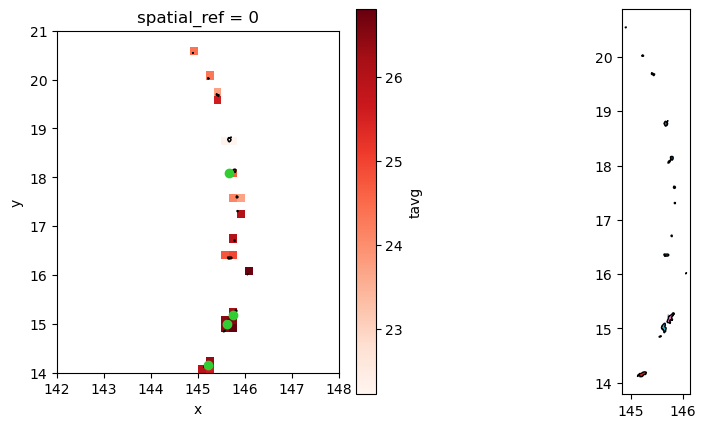

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_raster.plot(cmap="Reds", ax=ax[0])
nmi.plot(facecolor="None", edgecolor="black", ax=ax[0])
nmi.centroid.plot(color="limegreen", ax=ax[0])

nmi.plot(column="GID_2", edgecolor="black", ax=ax[1])

plt.show()


In [37]:
nmi["polygon_id"] = nmi.index.values
print(len(nmi))
print(len(np.unique(nmi["polygon_id"])))


4
4


Let's try the raster burn method again for just this subset of polygons.

In [38]:
gdf = nmi
data = raster
load_data = True
interp = None
clip = False

start = timeit.default_timer()
#---------------------------------------------------------------------------

if clip:
    # Clip to the external bounds of the input geometry
    # minx, miny, maxx, maxy = vector_grid.total_bounds
    # data = data.sel(x=slice(minx, maxx), y=slice(miny, maxy))

    # in our case, the geometry is the whole world, either land or ocean grid
    min_x, max_x = data.x.min().values, data.x.max().values
    min_y, max_y = data.y.min().values, data.y.max().values

# Interpolate to a finer grid first
if interp is not None and interp > 1:
    new_x  = np.linspace( data.x[0], data.x[-1], int(len(data.x) * interp) )
    new_y  = np.linspace( data.y[0], data.y[-1], int(len(data.y) * interp) )
    data = data.interp( x = new_x, y = new_y, method='nearest' )

# Load data to disk before analysis (much quicker).
if load_data:
    data = data.load()

# Burn polygon indices ('index' in dataframe ) onto same raster as data
burned = make_geocube( vector_data = gdf,
                       measurements = ["polygon_id"],
                      resolution = (0.25, 0.25),)
                       #like = data )

# Get indices of rasters that successfully burned (some will have been too small)
#success_idx = np.unique( burned.polygon_id ).astype(int) # this line will convert float nan to 0, which seems like a bug
success_idx = np.array([int(success) for success in np.unique( burned.polygon_id ).tolist() if np.isnan(success) == False])
success_idx = success_idx[ success_idx >=0 ]

#---------------------------------------------------------------------------
end = timeit.default_timer()
print(f"Time to complete: {(end - start):.5f}s")


Time to complete: 0.01870s


In [39]:
cent = nmi.centroid
cent_x = [cc.x for cc in cent]
cent_y = [cc.y for cc in cent]

print(cent)
print()
# print(cent_x)
# print(cent_y)
# print()

data_cent = raster.interp( 
    x = xr.DataArray( cent_x ), 
    y = xr.DataArray( cent_y ),
    method="nearest"
)

print(plot_raster)
print()
print(data_cent)


47597    POINT (145.67061 18.07970)
47598    POINT (145.21399 14.15749)
47599    POINT (145.75400 15.18932)
47600    POINT (145.62675 15.00248)
dtype: geometry

<xarray.DataArray 'tavg' (band: 1, y: 42, x: 36)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 142.1 142.2 142.4 142.6 ... 147.4 147.6 147.7 147.9
  * y            (y) float64 20.92 20.75 20.58 20.42 ... 14.58 14.42 14.25 14.08
    spatial_ref  int64 0
    polygon_id   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  34.009499740601
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -45.884000024796
    STATISTICS_STD

In [40]:
nmi["polygon_mean"] = data_cent.values.squeeze()
nmi[["COUNTRY", "GID_1", "GID_2", "polygon_id", "polygon_mean", "geometry"]].head()


,COUNTRY,GID_1,GID_2,polygon_id,polygon_mean,geometry
47597,Northern Mariana Islands,MNP.1_1,MNP.1_1,47597,24.689831,"MULTIPOLYGON (((146.05806 16.01222, 146.05472 ..."
47598,Northern Mariana Islands,MNP.2_1,MNP.2_1,47598,25.615789,"MULTIPOLYGON (((145.23944 14.20111, 145.26222 ..."
47599,Northern Mariana Islands,MNP.3_1,MNP.3_1,47599,26.198936,"MULTIPOLYGON (((145.81250 15.29028, 145.82028 ..."
47600,Northern Mariana Islands,MNP.4_1,MNP.4_1,47600,26.471052,"MULTIPOLYGON (((145.64528 15.10111, 145.65639 ..."


In [41]:
test_interp_array = plot_raster.data[0]
x = np.arange(0, test_interp_array.shape[1])
y = np.arange(0, test_interp_array.shape[0])
#mask invalid values
array = np.ma.masked_invalid(test_interp_array)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]

# https://stackoverflow.com/questions/37662180/interpolate-missing-values-2d-python
GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')


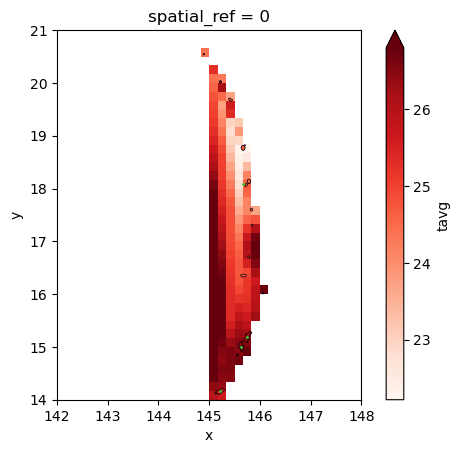

In [42]:
fig, ax = plt.subplots()

vmin, vmax = np.nanmin(plot_raster), np.nanmax(plot_raster)
plot_raster.data = np.expand_dims(GD1, axis=0)
plot_raster.plot(cmap="Reds", vmin=vmin, vmax=vmax, ax=ax)
nmi.plot(facecolor=None, edgecolor="black", ax=ax)
nmi.plot(column="polygon_mean", cmap="Reds", vmin=vmin, vmax=vmax, ax=ax)
nmi.centroid.plot(color="limegreen", markersize=1, ax=ax)

plt.show()


Now you could use this data and the centroid would have something representative to "burn" into the polygons.

In [43]:
cent = nmi.centroid
cent_x = [cc.x for cc in cent]
cent_y = [cc.y for cc in cent]

print(cent)
print()
# print(cent_x)
# print(cent_y)
# print()

data_cent = plot_raster.interp( 
    x = xr.DataArray( cent_x ), 
    y = xr.DataArray( cent_y ),
    method="nearest"
)


47597    POINT (145.67061 18.07970)
47598    POINT (145.21399 14.15749)
47599    POINT (145.75400 15.18932)
47600    POINT (145.62675 15.00248)
dtype: geometry



In [44]:
nmi["polygon_mean"] = data_cent.values.squeeze()
nmi[["COUNTRY", "GID_1", "GID_2", "polygon_id", "polygon_mean", "geometry"]].head()


,COUNTRY,GID_1,GID_2,polygon_id,polygon_mean,geometry
47597,Northern Mariana Islands,MNP.1_1,MNP.1_1,47597,24.689831,"MULTIPOLYGON (((146.05806 16.01222, 146.05472 ..."
47598,Northern Mariana Islands,MNP.2_1,MNP.2_1,47598,25.615789,"MULTIPOLYGON (((145.23944 14.20111, 145.26222 ..."
47599,Northern Mariana Islands,MNP.3_1,MNP.3_1,47599,26.198936,"MULTIPOLYGON (((145.81250 15.29028, 145.82028 ..."
47600,Northern Mariana Islands,MNP.4_1,MNP.4_1,47600,26.471052,"MULTIPOLYGON (((145.64528 15.10111, 145.65639 ..."


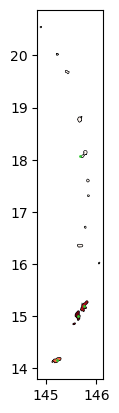

In [45]:
fig, ax = plt.subplots()

nmi.plot(facecolor=None, edgecolor="black", ax=ax)
nmi.plot(column="polygon_mean", cmap="Reds", ax=ax)
nmi.centroid.plot(color="limegreen", markersize=1, ax=ax)

plt.show()


You can see this isn't a perfct solution, because multiple islands are represented with a single value that doesn't represent the range of values present in the data. But it is better than including no data at all.

#### Puerto Rico

In [46]:
puerto_rico = world[world.COUNTRY == "Puerto Rico"]
bounding_box = puerto_rico.total_bounds
puerto_rico["polygon_id"] = puerto_rico.index.values

plot_raster = raster.sel(x=slice(-68, -64), y=slice(19, 17))
plot_raster


<xarray.DataArray 'tavg' (band: 1, y: 12, x: 24)>
array([[[      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan, 25.545834, 25.5     ,       nan],
        [      nan,       nan,       nan,       nan,       nan,
         23.796   ,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan, 25.05    ,       nan,       nan],
        [      nan,       nan,       nan, 24.25    , 23.764   ,
         23.173096, 22.551323, 22.81579 , 22.980108, 23.284746,
         23.697264, 24.25914 , 24.112406, 23.832142, 24.523077,
         24.8     , 24.96    , 24.76923 , 24.42295 , 24.373135,
         24.312222, 24.709091, 25.2     ,       nan],
...
        [      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -67.92 -67.75 -67.58 ... -64.42 -64.25 -64.08
  * y            (y) float64 18.92 18.75 18.58 18.42 ... 17.58 17.42 17.25 17.08
    spatial_ref  int64 0
    polygon_id   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  34.009499740601
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -45.884000024796
    STATISTICS_STDDEV:   nan

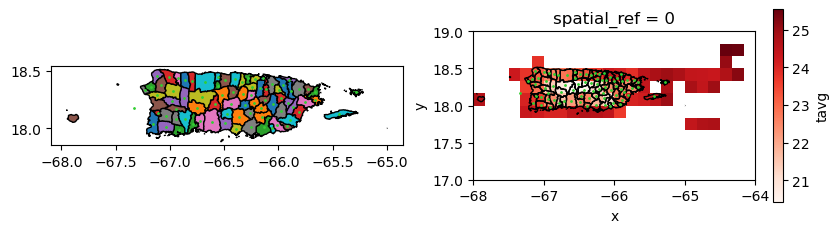

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

puerto_rico.plot(column="GID_2", edgecolor="black", ax=ax[0])
puerto_rico.centroid.plot(color="limegreen", markersize=1, ax=ax[0])

plot_raster.plot(cmap="Reds", cbar_kwargs={"shrink":0.25}, ax=ax[1])
puerto_rico.plot(facecolor="None", edgecolor="black", ax=ax[1])
puerto_rico.centroid.plot(color="limegreen", markersize=1, ax=ax[1])

plt.show()



You can see there is a centroid to the left of the image that is outside of any polygon.

In [48]:
cent = puerto_rico.centroid
cent_x = [cc.x for cc in cent]
cent_y = [cc.y for cc in cent]

print(cent)
print()
# print(cent_x)
# print(cent_y)
# print()

data_cent = plot_raster.interp( 
    x = xr.DataArray( cent_x ), 
    y = xr.DataArray( cent_y ),
    method="nearest"
)

print(plot_raster)
print()
print(data_cent)


47663    POINT (-66.75430 18.18020)
47664    POINT (-67.17508 18.36017)
47665    POINT (-67.12079 18.45978)
47666    POINT (-66.12672 18.25162)
47667    POINT (-66.26414 18.13129)
                    ...            
47736    POINT (-66.39780 18.42825)
47737    POINT (-65.44129 18.12325)
47738    POINT (-66.47309 18.12797)
47739    POINT (-65.89642 18.07031)
47740    POINT (-66.85871 18.08042)
Length: 78, dtype: geometry

<xarray.DataArray 'tavg' (band: 1, y: 12, x: 24)>
array([[[      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,
               nan,    

In [49]:
puerto_rico["polygon_mean"] = data_cent.values.squeeze()
puerto_rico[["COUNTRY", "GID_1", "GID_2", "polygon_id", "polygon_mean", "geometry"]].head(22)


,COUNTRY,GID_1,GID_2,polygon_id,polygon_mean,geometry
47663,Puerto Rico,PRI.1_1,PRI.1_1,47663,20.823000,"POLYGON ((-66.76633 18.13487, -66.78529 18.137..."
47664,Puerto Rico,PRI.2_1,PRI.2_1,47664,23.764000,"POLYGON ((-67.16003 18.41542, -67.15856 18.413..."
47665,Puerto Rico,PRI.3_1,PRI.3_1,47665,23.173096,"POLYGON ((-67.13233 18.38951, -67.13833 18.387..."
47666,Puerto Rico,PRI.4_1,PRI.4_1,47666,22.419500,"POLYGON ((-66.19061 18.25852, -66.18462 18.268..."
47667,Puerto Rico,PRI.5_1,PRI.5_1,47667,21.814501,"POLYGON ((-66.31466 18.15183, -66.31007 18.159..."
47668,Puerto Rico,PRI.6_1,PRI.6_1,47668,22.879545,"POLYGON ((-67.18282 18.31310, -67.17270 18.318..."
47669,Puerto Rico,PRI.7_1,PRI.7_1,47669,22.815790,"POLYGON ((-66.76542 18.48363, -66.74097 18.474..."
47670,Puerto Rico,PRI.8_1,PRI.8_1,47670,24.454369,"POLYGON ((-66.01982 17.97820, -66.02375 17.976..."
47671,Puerto Rico,PRI.9_1,PRI.9_1,47671,22.980108,"POLYGON ((-66.58799 18.38971, -66.59145 18.391..."
47672,Puerto Rico,PRI.10_1,PRI.10_1,47672,21.150999,"POLYGON ((-66.24267 18.18019, -66.24773 18.174..."


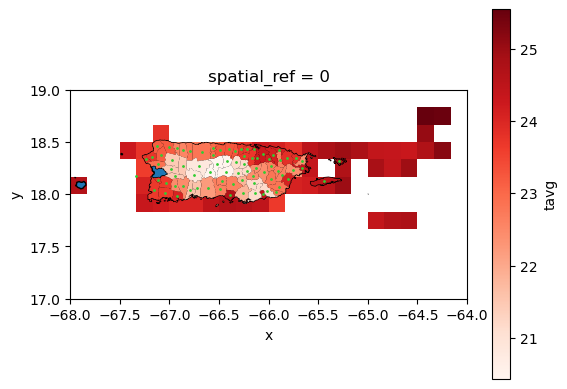

In [50]:
fig, ax = plt.subplots()

vmin, vmax = np.nanmin(plot_raster), np.nanmax(plot_raster)
plot_raster.plot(cmap="Reds", vmin=vmin, vmax=vmax, ax=ax)
puerto_rico.plot(facecolor=None, edgecolor="black", ax=ax)
puerto_rico.plot(column="polygon_mean", cmap="Reds", vmin=vmin, vmax=vmax, ax=ax)
puerto_rico.centroid.plot(color="limegreen", markersize=1, ax=ax)

plt.show()


In [51]:
test_interp_array = plot_raster.data[0]
x = np.arange(0, test_interp_array.shape[1])
y = np.arange(0, test_interp_array.shape[0])
#mask invalid values
array = np.ma.masked_invalid(test_interp_array)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]

GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')


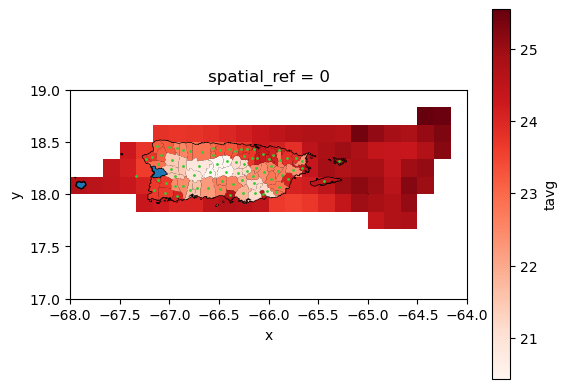

In [52]:
fig, ax = plt.subplots()

plot_raster.data = np.expand_dims(GD1, axis=0)
plot_raster.plot(cmap="Reds", vmin=vmin, vmax=vmax, ax=ax)
puerto_rico.plot(facecolor=None, edgecolor="black", ax=ax)
puerto_rico.plot(column="polygon_mean", cmap="Reds", vmin=vmin, vmax=vmax, ax=ax)
puerto_rico.centroid.plot(color="limegreen", markersize=1, ax=ax)

plt.show()


In [53]:
cent = puerto_rico.centroid
cent_x = [cc.x for cc in cent]
cent_y = [cc.y for cc in cent]

print(cent)
print()
# print(cent_x)
# print(cent_y)
# print()

data_cent = plot_raster.interp( 
    x = xr.DataArray( cent_x ), 
    y = xr.DataArray( cent_y ),
    method="nearest"
)


47663    POINT (-66.75430 18.18020)
47664    POINT (-67.17508 18.36017)
47665    POINT (-67.12079 18.45978)
47666    POINT (-66.12672 18.25162)
47667    POINT (-66.26414 18.13129)
                    ...            
47736    POINT (-66.39780 18.42825)
47737    POINT (-65.44129 18.12325)
47738    POINT (-66.47309 18.12797)
47739    POINT (-65.89642 18.07031)
47740    POINT (-66.85871 18.08042)
Length: 78, dtype: geometry



In [54]:
puerto_rico["polygon_mean"] = data_cent.values.squeeze()
puerto_rico[["COUNTRY", "GID_1", "GID_2", "polygon_id", "polygon_mean", "geometry"]].head()


,COUNTRY,GID_1,GID_2,polygon_id,polygon_mean,geometry
47663,Puerto Rico,PRI.1_1,PRI.1_1,47663,20.823000,"POLYGON ((-66.76633 18.13487, -66.78529 18.137..."
47664,Puerto Rico,PRI.2_1,PRI.2_1,47664,23.764000,"POLYGON ((-67.16003 18.41542, -67.15856 18.413..."
47665,Puerto Rico,PRI.3_1,PRI.3_1,47665,23.173096,"POLYGON ((-67.13233 18.38951, -67.13833 18.387..."
47666,Puerto Rico,PRI.4_1,PRI.4_1,47666,22.419500,"POLYGON ((-66.19061 18.25852, -66.18462 18.268..."
47667,Puerto Rico,PRI.5_1,PRI.5_1,47667,21.814501,"POLYGON ((-66.31466 18.15183, -66.31007 18.159..."


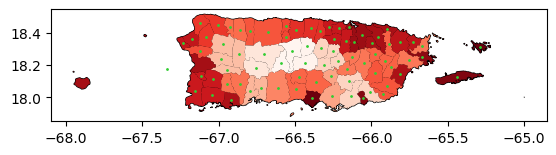

In [55]:
fig, ax = plt.subplots()

#plot_raster.plot(cmap="Reds", ax=ax)
puerto_rico.plot(facecolor=None, edgecolor="black", ax=ax)
puerto_rico.plot(column="polygon_mean", cmap="Reds", ax=ax)
puerto_rico.centroid.plot(color="limegreen", markersize=1, ax=ax)

plt.show()
